<a href="https://colab.research.google.com/github/max-poltora/fertilizer_particles_recognizer/blob/main/Train_unet_to_recognize_fertilizer_particles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect to google drive

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


Import libraries for preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from random import shuffle

In [3]:
imgdir = '/content/drive/MyDrive/Colab Notebooks/Fertilizer particles/Images'
mskdir = '/content/drive/MyDrive/Colab Notebooks/Fertilizer particles/Masks'


In [4]:
batch_size = 5
img_width = 512
img_height = 512
img_channels = 3

def image_generator(files, batch_size = batch_size, target_size = (img_width, img_height)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for file in batch:

        #get and preprocess images 
        img = Image.open(f'{imgdir}/{file}')
        img = np.array(img.resize(target_size))

        batch_x.append(img)
        
        #get and preprocess masks 
        msk = Image.open(f'{mskdir}/{file}')
        msk = msk.convert('1')
        msk = np.array(msk.resize(target_size))

        batch_y.append(msk)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.expand_dims(batch_y, 3)

    yield (batch_x, batch_y)      
    

In [5]:
all_files = os.listdir(imgdir)
shuffle(all_files)

split = int(0.8 * len(all_files)) # 80%

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files)
test_generator  = image_generator(test_files)

In [6]:
x, y = next(train_generator)

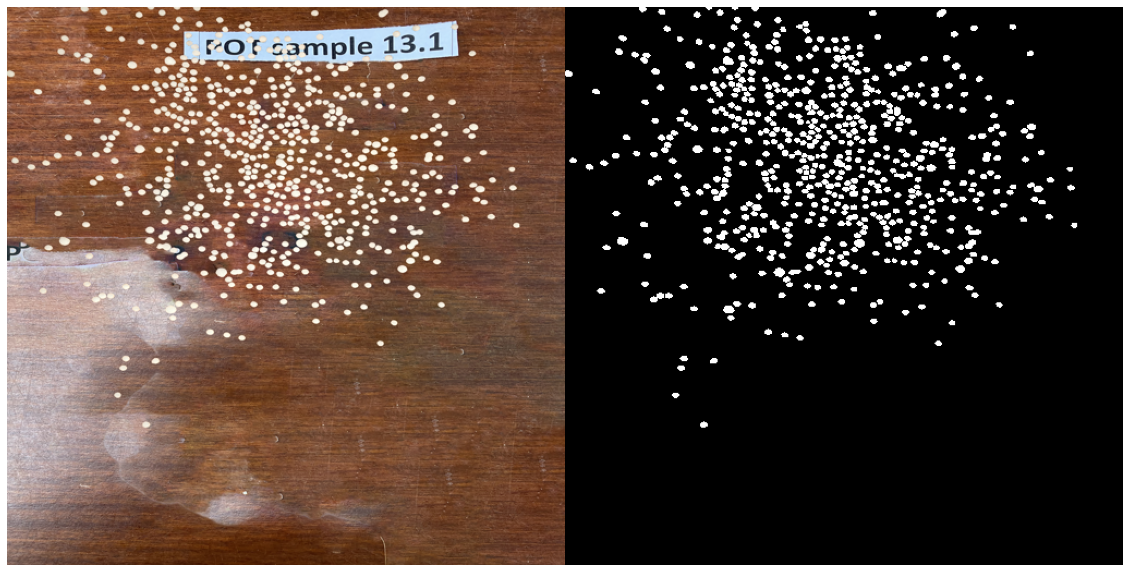

In [7]:
plt.figure(figsize=(20,20))
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow(np.concatenate([img, msk], axis = 1))


Import libraries for the model

In [6]:
import tensorflow as tf
import keras
from keras.layers import *
from keras.models import Model
from keras.metrics import MeanIoU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils.vis_utils import plot_model


In [ ]:
# Custom MeanIoU Metric function
class MeanIoU(tf.keras.metrics.Metric):
  def __init__(self, num_classes, thres=0.5, name='mean_iou', dtype=None):
    super(MeanIoU, self).__init__(name=name, dtype=dtype)
    self.num_classes = num_classes
    self.thres = thres
    self.total_cm = self.add_weight('total_confusion_matrix',
                                   shape=(num_classes, num_classes),
                                 initializer=tf.zeros_initializer())
  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.cast(y_true, self._dtype)
    y_pred = tf.cast(y_pred, self._dtype)
    if y_pred.shape.ndims > 1:
      y_pred = tf.reshape(y_pred, [-1])
    if y_true.shape.ndims > 1:
      y_true = tf.reshape(y_true, [-1])
    y_pred = tf.where(y_pred > self.thres, 1.0, 0.0)
    if sample_weight is not None:
      sample_weight = tf.cast(sample_weight, self._dtype)
      if sample_weight.shape.ndims > 1:
        sample_weight = tf.reshape(sample_weight, [-1])
    current_cm = tf.math.confusion_matrix(y_true,
                                          y_pred,
                                          self.num_classes,
                                          weights=sample_weight,
                                          dtype=self._dtype)
    return self.total_cm.assign_add(current_cm)
  
  def result(self):
    sum_over_row = tf.cast(tf.reduce_sum(self.total_cm, axis=0), dtype=self._dtype)
    sum_over_col = tf.cast(tf.reduce_sum(self.total_cm, axis=1), dtype=self._dtype)
    true_positives = tf.cast(tf.linalg.tensor_diag_part(self.total_cm), dtype=self._dtype)
    denominator = sum_over_row + sum_over_col - true_positives
    num_valid_entries = tf.reduce_sum(tf.cast(tf.math.not_equal(denominator, 0), dtype=self._dtype))
    iou = tf.math.divide_no_nan(true_positives, denominator)
    return tf.math.divide_no_nan(tf.reduce_sum(iou, name='mean_iou'), num_valid_entries)
  def reset_states(self):
    # The state of the metric will be reset at the start of each epoch.
    tf.keras.backend.set_value(self.total_cm, np.zeros((self.num_classes, self.num_classes)))
  def get_config(self):
    config = {'num_classes': self.num_classes}
    base_config = super(MeanIoU, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

mean_iou = MeanIoU(2, 0.4)

Define Unet model

In [7]:
def unet(pretrained_weights=None, input_size=(img_width, img_height, img_channels)):
  
  input = Input(input_size)

  # Contraction path
  c1 = Conv2D(filters=64, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(input)
  c1 = Dropout(0.1)(c1)
  c1 = Conv2D(filters=64, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPool2D(pool_size=(2,2))(c1)

  c2 = Conv2D(filters=128, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv2D(filters=128, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPool2D(pool_size=(2,2))(c2)

  c3 = Conv2D(filters=256, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(filters=256, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPool2D(pool_size=(2,2))(c3)

  c4 = Conv2D(filters=512, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(filters=512, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPool2D(pool_size=(2,2))(c4)

  c5 = Conv2D(filters=1024, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(filters=1024, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  # Upsampling path
  u6 = Conv2DTranspose(filters=512, kernel_size=(2,2), strides=(2,2), padding="same")(c5) 
  merge6 = concatenate([u6, c4])
  c6 = Conv2D(filters=512, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(merge6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(filters=512, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(filters=256, kernel_size=(2,2), strides=(2,2), padding="same")(c6) 
  merge7 = concatenate([u7, c3])
  c7 = Conv2D(filters=256, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(merge7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(filters=256, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(filters=128, kernel_size=(2,2), strides=(2,2), padding="same")(c7) 
  merge8 = concatenate([u8, c2])
  c8 = Conv2D(filters=128, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(merge8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv2D(filters=128, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2,2), padding="same")(c8) 
  merge9 = concatenate([u9, c1])
  c9 = Conv2D(filters=64, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(merge9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv2D(filters=64, kernel_size=(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  output = Conv2D(filters=1, kernel_size=(1,1), activation="sigmoid")(c9)

  model = Model(inputs=input, outputs=output)

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

  if(pretrained_weights):
    	model.load_weights(pretrained_weights)

  # model.summary()

  return model

model = unet(pretrained_weights = '/content/drive/MyDrive/Fertilizer particles recognizer.h5')

Callbacks

In [8]:
callbacks = [
             EarlyStopping(patience=2),
             ModelCheckpoint(filepath='/content/drive/MyDrive/Fertilizer particles recognizer.h5', 
                             verbose=0, save_best_only=True, save_weights_only=True, monitor='val_loss')
]

Training

In [ ]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = callbacks,
                    initial_epoch = 3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 4/30
253/253 [==============================] - 1431s 6s/step - loss: 0.0259 - accuracy: 0.9901 - val_loss: 0.0270 - val_accuracy: 0.9914
Epoch 5/30
253/253 [==============================] - 1053s 4s/step - loss: 0.0179 - accuracy: 0.9928 - val_loss: 0.0224 - val_accuracy: 0.9927
Epoch 6/30
253/253 [==============================] - 1004s 4s/step - loss: 0.0158 - accuracy: 0.9937 - val_loss: 0.0164 - val_accuracy: 0.9944
Epoch 7/30
253/253 [==============================] - 1017s 4s/step - loss: 0.0143 - accuracy: 0.9942 - val_loss: 0.0149 - val_accuracy: 0.9945
Epoch 8/30
253/253 [==============================] - 992s 4s/step - loss: 0.0130 - accuracy: 0.9947 - val_loss: 0.0129 - val_accuracy: 0.9951
Epoch 9/30
253/253 [==============================] - 983s 4s/step - loss: 0.0125 - accuracy: 0.9949 - val_loss: 0.0113 - val_accuracy: 0.9957
Epoch 10/30
173/253 [===================>..........] - ETA: 4:15 - loss: 0.0117 - accuracy: 0.9952

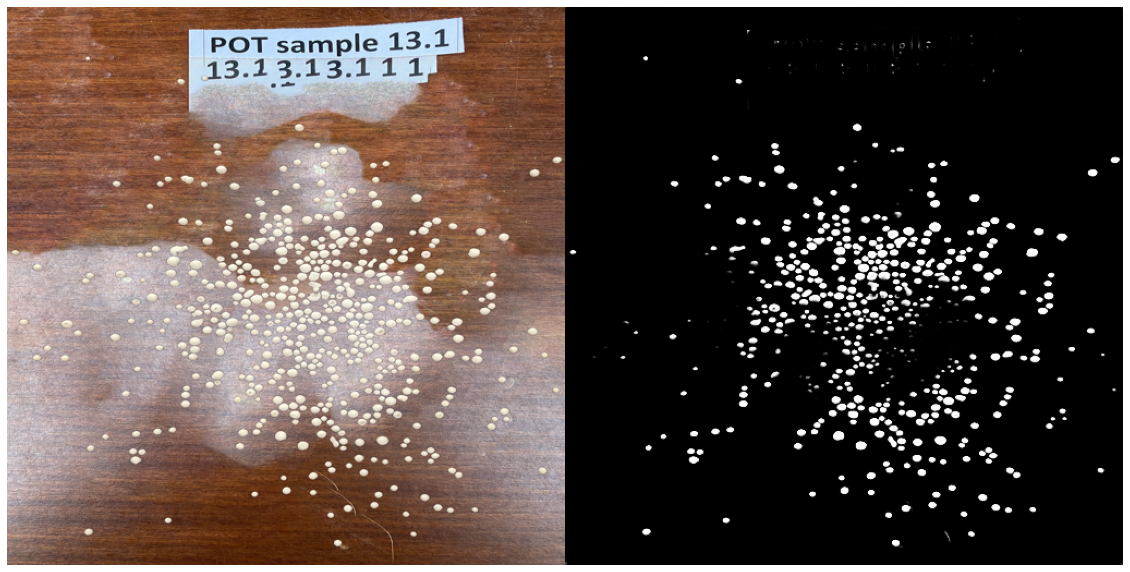

In [9]:
path = np.random.choice(test_files)
raw = Image.open(f'{imgdir}/{path}')
raw = np.array(raw.resize((img_width, img_height)))/255.
raw = raw[:,:,0:3]
        
#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))
        
#mask post-processing 
msk = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
        
#show the mask and the segmented image 
combined = np.concatenate([raw, msk], axis = 1)
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(combined)
plt.show()

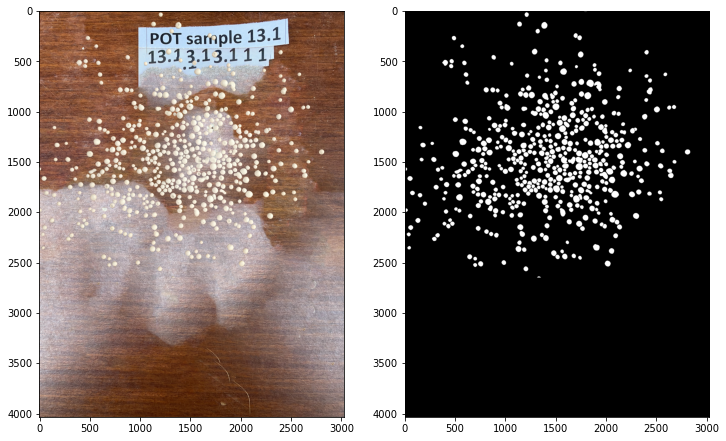

In [ ]:
path = np.random.choice(test_files)

img = Image.open(f'{imgdir}/{path}')
msk = Image.open(f'{mskdir}/{path}')
msk = msk.convert('1')
f, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(img)
ax[1].imshow(msk)



In [ ]:
path = np.random.choice(test_files)

msk = Image.open(f'{mskdir}/{path}')

msk = msk.convert('1')
unique, counts = np.unique(msk, return_counts=True)
pd.DataFrame({'Values': unique, 'Counts': counts})



,Values,Counts
0,False,11563875
1,True,628893


In [ ]:
MeanIoU(2, 0.4)

TypeError: ignored